HPC Fluid Dynamics Simulation Project

This project demonstrates various parallel computing techniques:
1. Sequential (single-threaded) implementation
2. Multiprocessing (multi-core CPU) implementation
3. GPU-accelerated implementation using PyTorch

GPU acceleration available: Tesla T4

Running performance benchmarks...
Starting HPC Fluid Simulation Benchmark

Running benchmarks for grid size: 64x64
  Running sequential implementation...
    Average step time: 0.0388 seconds
  Running multiprocessing implementation...
    Average step time: 0.4000 seconds
  Running gpu implementation...


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


    Average step time: 0.6538 seconds

Running benchmarks for grid size: 128x128
  Running sequential implementation...
    Average step time: 0.1870 seconds
  Running multiprocessing implementation...
    Average step time: 1.5363 seconds
  Running gpu implementation...
    Average step time: 2.4545 seconds

Running benchmarks for grid size: 256x256
  Running sequential implementation...
    Average step time: 0.5895 seconds
  Running multiprocessing implementation...
    Average step time: 5.8095 seconds
  Running gpu implementation...
    Average step time: 9.4691 seconds

Speedup Analysis

Grid size: 64x64
  Multiprocessing vs Sequential: 0.10x speedup
  Gpu vs Sequential: 0.06x speedup

Grid size: 128x128
  Multiprocessing vs Sequential: 0.12x speedup
  Gpu vs Sequential: 0.08x speedup

Grid size: 256x256
  Multiprocessing vs Sequential: 0.10x speedup
  Gpu vs Sequential: 0.06x speedup

Generating performance visualization...


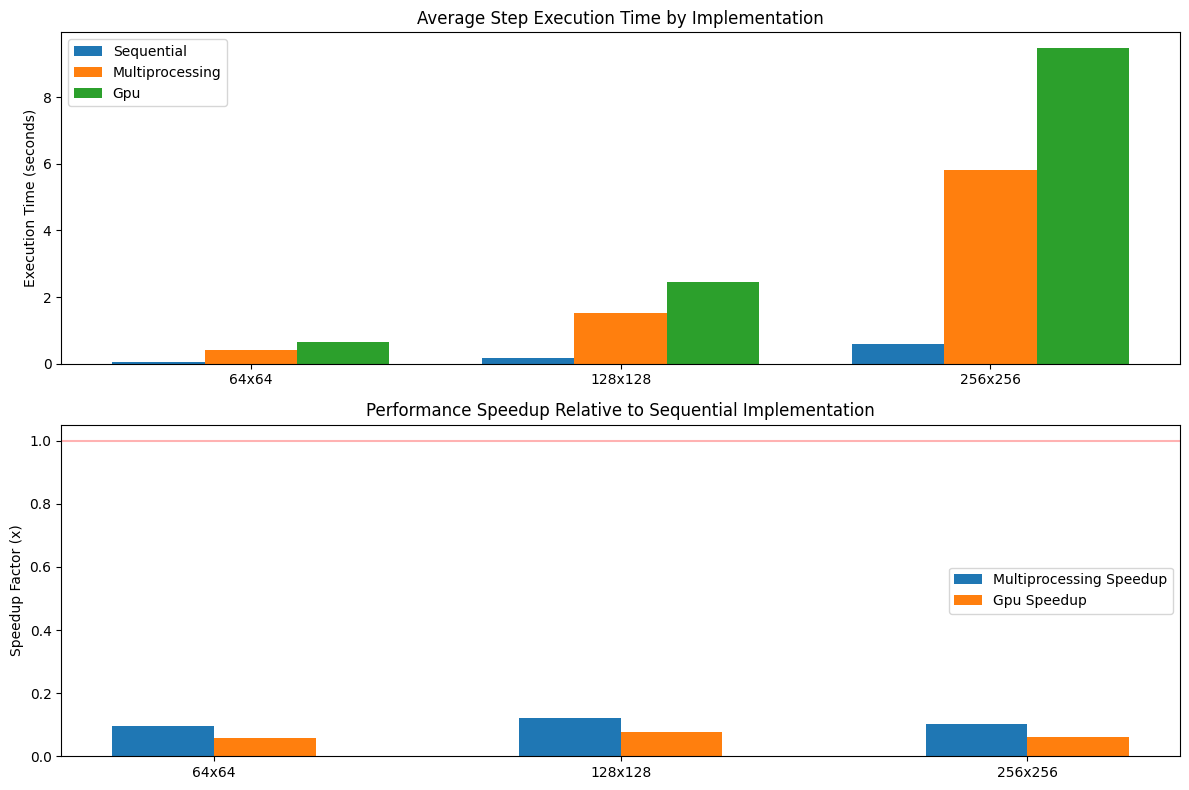


Creating fluid simulation animation using gpu implementation...
Creating fluid simulation animation using gpu implementation


  0%|          | 0/100 [00:00<?, ?it/s]

Animation saved as 'fluid_simulation.mp4'

Project completed successfully!


In [ ]:
# HPC Project: Parallel Fluid Dynamics Simulation
# Demonstrates parallelization techniques on Google Colab

from multiprocessing import pool
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import time
import multiprocessing as mp
import torch
import torch.nn.functional as F
from functools import partial
from tqdm.notebook import tqdm

class ParallelFluidSimulation:
    """
    2D fluid simulation using the Navier-Stokes equations
    with parallel implementation strategies
    """

    def __init__(self, size=256, viscosity=0.1, dt=0.1, diffusion=0.0001):
        self.size = size
        self.viscosity = viscosity
        self.dt = dt
        self.diffusion = diffusion

        # Initialize velocity fields and density field
        self.u = np.zeros((size, size))  # x-velocity
        self.v = np.zeros((size, size))  # y-velocity
        self.u_prev = np.zeros((size, size))
        self.v_prev = np.zeros((size, size))
        self.density = np.zeros((size, size))
        self.density_prev = np.zeros((size, size))

        # For GPU computation
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def add_density(self, x, y, amount):
        """Add density at a specific position"""
        self.density[x, y] += amount

    def add_velocity(self, x, y, amount_x, amount_y):
        """Add velocity at a specific position"""
        self.u[x, y] += amount_x
        self.v[x, y] += amount_y

    def diffuse_sequential(self, field, prev_field, diff, dt):
        """Sequential implementation of diffusion step"""
        a = dt * diff * self.size * self.size

        for k in range(20):  # Gauss-Seidel relaxation
            field[1:-1, 1:-1] = (prev_field[1:-1, 1:-1] +
                               a * (field[2:, 1:-1] + field[:-2, 1:-1] +
                                    field[1:-1, 2:] + field[1:-1, :-2])) / (1 + 4 * a)

            # Set boundary conditions
            field[0, :] = field[1, :]  # Left
            field[-1, :] = field[-2, :]  # Right
            field[:, 0] = field[:, 1]  # Top
            field[:, -1] = field[:, -2]  # Bottom

        return field

    def diffuse_multiprocessing(self, field, prev_field, diff, dt):
        """Multi-core CPU implementation of diffusion step using Python multiprocessing"""
        a = dt * diff * self.size * self.size
        field_copy = field.copy()

        # Split the grid into chunks for each CPU core
        num_cores = mp.cpu_count()
        chunk_size = max(2, self.size // num_cores)
        chunks = [(i, min(i + chunk_size, self.size)) for i in range(0, self.size, chunk_size)]

        with mp.Pool() as pool:
            results = pool.starmap(partial(self.process_chunk, field_copy=field_copy, prev_field=prev_field, a=a, size=self.size), chunks)

        # Combine results
        for start_row, end_row, chunk_data in results:
            field[start_row:end_row, :] = chunk_data

        # Set boundary conditions
        field[0, :] = field[1, :]  # Left
        field[-1, :] = field[-2, :]  # Right
        field[:, 0] = field[:, 1]  # Top
        field[:, -1] = field[:, -2]  # Bottom

        return field

    def process_chunk(self, start_row, end_row, field_copy, prev_field, a, size):
        """Process a chunk of the grid for multiprocessing"""
        local_field = field_copy.copy()

        for k in range(20):  # Gauss-Seidel relaxation
            for i in range(start_row, end_row):
                if i == 0 or i == size - 1:
                    continue

                for j in range(1, size - 1):
                    local_field[i, j] = (prev_field[i, j] +
                                      a * (local_field[i+1, j] + local_field[i-1, j] +
                                           local_field[i, j+1] + local_field[i, j-1])) / (1 + 4 * a)

        return (start_row, end_row, local_field[start_row:end_row, :])

    def diffuse_gpu(self, field, prev_field, diff, dt):
        """GPU implementation of diffusion step using PyTorch"""
        a = dt * diff * self.size * self.size

        # Convert NumPy arrays to PyTorch tensors on GPU
        field_tensor = torch.from_numpy(field).float().to(self.device)
        prev_field_tensor = torch.from_numpy(prev_field).float().to(self.device)

        for k in range(20):  # Gauss-Seidel relaxation
            # Update inner cells
            field_tensor[1:-1, 1:-1] = (prev_field_tensor[1:-1, 1:-1] +
                                      a * (field_tensor[2:, 1:-1] + field_tensor[:-2, 1:-1] +
                                           field_tensor[1:-1, 2:] + field_tensor[1:-1, :-2])) / (1 + 4 * a)

            # Set boundary conditions
            field_tensor[0, :] = field_tensor[1, :]  # Left
            field_tensor[-1, :] = field_tensor[-2, :]  # Right
            field_tensor[:, 0] = field_tensor[:, 1]  # Top
            field_tensor[:, -1] = field_tensor[:, -2]  # Bottom

        # Convert back to NumPy array
        return field_tensor.cpu().numpy()

    def advect_sequential(self, field, u, v, dt):
        """Sequential implementation of advection step"""
        size = self.size
        dt0 = dt * size

        new_field = np.zeros_like(field)

        for i in range(1, size - 1):
            for j in range(1, size - 1):
                # Trace particle position backward in time
                x = i - dt0 * u[i, j]
                y = j - dt0 * v[i, j]

                # Clamp positions to grid boundaries
                x = max(0.5, min(size - 1.5, x))
                y = max(0.5, min(size - 1.5, y))

                # Get integer indices for bilinear interpolation
                i0, j0 = int(x), int(y)
                i1, j1 = i0 + 1, j0 + 1

                # Get interpolation weights
                s1 = x - i0
                s0 = 1 - s1
                t1 = y - j0
                t0 = 1 - t1

                # Perform bilinear interpolation
                new_field[i, j] = (s0 * (t0 * field[i0, j0] + t1 * field[i0, j1]) +
                                  s1 * (t0 * field[i1, j0] + t1 * field[i1, j1]))

        # Set boundary conditions
        new_field[0, :] = new_field[1, :]  # Left
        new_field[-1, :] = new_field[-2, :]  # Right
        new_field[:, 0] = new_field[:, 1]  # Top
        new_field[:, -1] = new_field[:, -2]  # Bottom

        return new_field

    def advect_gpu(self, field, u, v, dt):
        """GPU implementation of advection step using manual interpolation"""
        size = self.size
        dt0 = dt * size

        # Convert NumPy arrays to PyTorch tensors on GPU
        field_tensor = torch.from_numpy(field).float().to(self.device)
        u_tensor = torch.from_numpy(u).float().to(self.device)
        v_tensor = torch.from_numpy(v).float().to(self.device)

        # Create a grid of coordinates for the field (y, x)
        y_coords, x_coords = torch.meshgrid(torch.arange(size, device=self.device),
                                            torch.arange(size, device=self.device))

        # Compute the new positions of the particles by tracing back
        x_new = x_coords.float() - dt0 * u_tensor
        y_new = y_coords.float() - dt0 * v_tensor

        # Handle boundaries by applying periodic boundary conditions or clamping
        x_new = torch.clamp(x_new, 0, size - 1)  # Ensure the x-coordinate is within bounds
        y_new = torch.clamp(y_new, 0, size - 1)  # Ensure the y-coordinate is within bounds

        # Convert to integer indices for interpolation
        x_indices = x_new.long()
        y_indices = y_new.long()

        # Interpolate field values based on the new positions
        new_field_tensor = torch.zeros_like(field_tensor)

        for i in range(size):
            for j in range(size):
                # Get the indices for the current particle position
                xi, yi = x_indices[i, j], y_indices[i, j]
                new_field_tensor[i, j] = field_tensor[yi, xi]

        # Set boundary conditions (simple zero-gradient or periodic boundary handling)
        new_field_tensor[0, :] = new_field_tensor[1, :]  # Left boundary
        new_field_tensor[-1, :] = new_field_tensor[-2, :]  # Right boundary
        new_field_tensor[:, 0] = new_field_tensor[:, 1]  # Top boundary
        new_field_tensor[:, -1] = new_field_tensor[:, -2]  # Bottom boundary

        # Convert back to NumPy array
        return new_field_tensor.cpu().numpy()




    def project(self, u, v):
        """
        Project the velocity field to make it divergence-free
        (Helmholtz-Hodge decomposition)
        """
        size = self.size
        h = 1.0 / size

        # Calculate divergence
        div = np.zeros((size, size))
        p = np.zeros((size, size))

        div[1:-1, 1:-1] = -0.5 * h * (
            u[2:, 1:-1] - u[:-2, 1:-1] +
            v[1:-1, 2:] - v[1:-1, :-2]
        )

        # Set boundary conditions
        div[0, :] = 0
        div[-1, :] = 0
        div[:, 0] = 0
        div[:, -1] = 0

        # Solve Poisson equation ∇²p = div using Gauss-Seidel relaxation
        for k in range(20):
            p[1:-1, 1:-1] = (div[1:-1, 1:-1] +
                           p[2:, 1:-1] + p[:-2, 1:-1] +
                           p[1:-1, 2:] + p[1:-1, :-2]) / 4

            # Set boundary conditions
            p[0, :] = p[1, :]
            p[-1, :] = p[-2, :]
            p[:, 0] = p[:, 1]
            p[:, -1] = p[:, -2]

        # Subtract pressure gradient from velocity
        u[1:-1, 1:-1] -= 0.5 * (p[2:, 1:-1] - p[:-2, 1:-1]) / h
        v[1:-1, 1:-1] -= 0.5 * (p[1:-1, 2:] - p[1:-1, :-2]) / h

        # Set boundary conditions
        u[0, :] = 0
        u[-1, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
        v[0, :] = 0
        v[-1, :] = 0
        v[:, 0] = 0
        v[:, -1] = 0

        return u, v

    def project_gpu(self, u, v):
        """GPU implementation of projection step"""
        size = self.size
        h = 1.0 / size

        # Convert NumPy arrays to PyTorch tensors on GPU
        u_tensor = torch.from_numpy(u).float().to(self.device)
        v_tensor = torch.from_numpy(v).float().to(self.device)

        # Calculate divergence
        div = torch.zeros((size, size), device=self.device)
        p = torch.zeros((size, size), device=self.device)

        div[1:-1, 1:-1] = -0.5 * h * (
            u_tensor[2:, 1:-1] - u_tensor[:-2, 1:-1] +
            v_tensor[1:-1, 2:] - v_tensor[1:-1, :-2]
        )

        # Solve Poisson equation using Gauss-Seidel relaxation
        for k in range(20):
            p[1:-1, 1:-1] = (div[1:-1, 1:-1] +
                           p[2:, 1:-1] + p[:-2, 1:-1] +
                           p[1:-1, 2:] + p[1:-1, :-2]) / 4

            # Set boundary conditions
            p[0, :] = p[1, :]
            p[-1, :] = p[-2, :]
            p[:, 0] = p[:, 1]
            p[:, -1] = p[:, -2]

        # Subtract pressure gradient
        u_tensor[1:-1, 1:-1] -= 0.5 * (p[2:, 1:-1] - p[:-2, 1:-1]) / h
        v_tensor[1:-1, 1:-1] -= 0.5 * (p[1:-1, 2:] - p[1:-1, :-2]) / h

        # Set boundary conditions
        u_tensor[0, :] = 0
        u_tensor[-1, :] = 0
        u_tensor[:, 0] = 0
        u_tensor[:, -1] = 0
        v_tensor[0, :] = 0
        v_tensor[-1, :] = 0
        v_tensor[:, 0] = 0
        v_tensor[:, -1] = 0

        # Convert back to NumPy array
        return u_tensor.cpu().numpy(), v_tensor.cpu().numpy()

    def step_sequential(self):
        """Perform one simulation step using sequential implementation"""
        start_time = time.time()

        # Diffuse velocity
        self.u = self.diffuse_sequential(self.u.copy(), self.u, self.viscosity, self.dt)
        self.v = self.diffuse_sequential(self.v.copy(), self.v, self.viscosity, self.dt)

        # Project to make velocity field divergence-free
        self.u, self.v = self.project(self.u, self.v)

        # Advect velocity
        self.u = self.advect_sequential(self.u, self.u, self.v, self.dt)
        self.v = self.advect_sequential(self.v, self.u, self.v, self.dt)

        # Project again
        self.u, self.v = self.project(self.u, self.v)

        # Diffuse density
        self.density = self.diffuse_sequential(self.density.copy(), self.density, self.diffusion, self.dt)

        # Advect density
        self.density = self.advect_sequential(self.density, self.u, self.v, self.dt)

        end_time = time.time()
        return end_time - start_time

    def step_multiprocessing(self):
        """Perform one simulation step using multiprocessing"""
        start_time = time.time()

        # Diffuse velocity
        self.u = self.diffuse_multiprocessing(self.u.copy(), self.u, self.viscosity, self.dt)
        self.v = self.diffuse_multiprocessing(self.v.copy(), self.v, self.viscosity, self.dt)

        # Project to make velocity field divergence-free
        self.u, self.v = self.project(self.u, self.v)

        # Advect velocity
        self.u = self.advect_sequential(self.u, self.u, self.v, self.dt)
        self.v = self.advect_sequential(self.v, self.u, self.v, self.dt)

        # Project again
        self.u, self.v = self.project(self.u, self.v)

        # Diffuse density
        self.density = self.diffuse_multiprocessing(self.density.copy(), self.density, self.diffusion, self.dt)

        # Advect density
        self.density = self.advect_sequential(self.density, self.u, self.v, self.dt)

        end_time = time.time()
        return end_time - start_time

    def step_gpu(self):
        """Perform one simulation step using GPU acceleration"""
        start_time = time.time()

        # Diffuse velocity
        self.u = self.diffuse_gpu(self.u.copy(), self.u, self.viscosity, self.dt)
        self.v = self.diffuse_gpu(self.v.copy(), self.v, self.viscosity, self.dt)

        # Project to make velocity field divergence-free
        self.u, self.v = self.project_gpu(self.u, self.v)

        # Advect velocity
        self.u = self.advect_gpu(self.u, self.u, self.v, self.dt)
        self.v = self.advect_gpu(self.v, self.u, self.v, self.dt)

        # Project again
        self.u, self.v = self.project_gpu(self.u, self.v)

        # Diffuse density
        self.density = self.diffuse_gpu(self.density.copy(), self.density, self.diffusion, self.dt)

        # Advect density
        self.density = self.advect_gpu(self.density, self.u, self.v, self.dt)

        end_time = time.time()
        return end_time - start_time

# Run HPC benchmarks and demonstrations
def run_hpc_demo():
    """Run benchmark comparing different parallel implementations"""
    print("Starting HPC Fluid Simulation Benchmark")
    print("=======================================")

    grid_sizes = [64, 128, 256]
    implementation_types = ['sequential', 'multiprocessing', 'gpu']
    results = {}

    for size in grid_sizes:
        print(f"\nRunning benchmarks for grid size: {size}x{size}")
        results[size] = {}

        for impl_type in implementation_types:
            if impl_type == 'gpu' and not torch.cuda.is_available():
                print("  GPU implementation: CUDA not available, skipping")
                results[size][impl_type] = None
                continue

            # Initialize simulation with the right size
            sim = ParallelFluidSimulation(size=size)

            # Add some initial fluid
            center = size // 2
            radius = size // 10
            for i in range(center-radius, center+radius):
                for j in range(center-radius, center+radius):
                    if (i-center)**2 + (j-center)**2 < radius**2:
                        sim.add_density(i, j, 1.0)
                        if i < center:
                            sim.add_velocity(i, j, 0.5, 0.0)
                        else:
                            sim.add_velocity(i, j, -0.5, 0.0)

            # Run simulation steps and measure time
            print(f"  Running {impl_type} implementation...")
            step_times = []

            for i in range(10):  # Run 10 steps for each implementation
                if impl_type == 'sequential':
                    step_time = sim.step_sequential()
                elif impl_type == 'multiprocessing':
                    step_time = sim.step_multiprocessing()
                elif impl_type == 'gpu':
                    step_time = sim.step_gpu()

                step_times.append(step_time)

            avg_time = sum(step_times) / len(step_times)
            results[size][impl_type] = avg_time
            print(f"    Average step time: {avg_time:.4f} seconds")

    # Display speedup results
    print("\nSpeedup Analysis")
    print("================")
    for size in grid_sizes:
        print(f"\nGrid size: {size}x{size}")
        baseline = results[size]['sequential']

        for impl_type in implementation_types:
            if impl_type == 'sequential':
                continue

            if results[size][impl_type] is None:
                print(f"  {impl_type.capitalize()} vs Sequential: N/A (not available)")
            else:
                speedup = baseline / results[size][impl_type]
                print(f"  {impl_type.capitalize()} vs Sequential: {speedup:.2f}x speedup")

    return results

def visualize_performance(results):
    """Create performance visualization charts"""
    grid_sizes = list(results.keys())
    impl_types = ['sequential', 'multiprocessing', 'gpu']

    plt.figure(figsize=(12, 8))

    # Execution time plot
    plt.subplot(2, 1, 1)
    bar_width = 0.25
    indices = np.arange(len(grid_sizes))

    for i, impl in enumerate(impl_types):
        times = []
        for size in grid_sizes:
            time_val = results[size].get(impl)
            times.append(time_val if time_val is not None else 0)

        plt.bar(indices + i*bar_width, times, bar_width, label=impl.capitalize())

    plt.ylabel('Execution Time (seconds)')
    plt.title('Average Step Execution Time by Implementation')
    plt.xticks(indices + bar_width, [f'{size}x{size}' for size in grid_sizes])
    plt.legend()

    # Speedup plot
    plt.subplot(2, 1, 2)
    for i, impl in enumerate(impl_types[1:]):  # Skip sequential as it's the baseline
        speedups = []
        for size in grid_sizes:
            baseline = results[size]['sequential']
            impl_time = results[size].get(impl)

            if impl_time is not None and impl_time > 0:
                speedups.append(baseline / impl_time)
            else:
                speedups.append(0)

        plt.bar(indices + (i-0.5)*bar_width, speedups, bar_width, label=f'{impl.capitalize()} Speedup')

    plt.ylabel('Speedup Factor (x)')
    plt.title('Performance Speedup Relative to Sequential Implementation')
    plt.xticks(indices, [f'{size}x{size}' for size in grid_sizes])
    plt.axhline(y=1, color='r', linestyle='-', alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig('hpc_performance_results.png')
    plt.show()

def create_animation(size=128, frames=100, implementation='gpu'):
    """Create an animation of the fluid simulation"""
    print(f"Creating fluid simulation animation using {implementation} implementation")

    sim = ParallelFluidSimulation(size=size)

    # Set up initial conditions
    center = size // 2
    radius = size // 8

    # Add multiple density sources
    for angle in range(0, 360, 60):
        x = int(center + radius * np.cos(np.radians(angle)))
        y = int(center + radius * np.sin(np.radians(angle)))

        for i in range(x-5, x+5):
            for j in range(y-5, y+5):
                if 0 <= i < size and 0 <= j < size:
                    sim.add_density(i, j, 1.0)
                    # Add velocity perpendicular to radius
                    vx = 2 * np.sin(np.radians(angle))
                    vy = -2 * np.cos(np.radians(angle))
                    sim.add_velocity(i, j, vx, vy)

    # Storage for animation frames
    density_frames = []

    # Simulation loop
    for i in tqdm(range(frames)):
        # Add some periodic forces
        if i % 20 == 0:
            angle = (i // 10) * 30
            x = int(center + radius * np.cos(np.radians(angle)))
            y = int(center + radius * np.sin(np.radians(angle)))

            for i2 in range(x-3, x+3):
                for j2 in range(y-3, y+3):
                    if 0 <= i2 < size and 0 <= j2 < size:
                        sim.add_density(i2, j2, 0.5)
                        sim.add_velocity(i2, j2, np.cos(np.radians(angle+90)), np.sin(np.radians(angle+90)))

        # Step the simulation using the specified implementation
        if implementation == 'sequential':
            sim.step_sequential()
        elif implementation == 'multiprocessing':
            sim.step_multiprocessing()
        else:  # gpu implementation
            sim.step_gpu()

        # Store the current density field
        density_frames.append(sim.density.copy())

    # Create animation
    fig, ax = plt.subplots(figsize=(8, 8))

    def update(frame):
        ax.clear()
        ax.set_xticks([])
        ax.set_yticks([])
        img = ax.imshow(density_frames[frame], cmap='inferno', vmin=0, vmax=1)
        ax.set_title(f'Fluid Simulation Frame {frame}')
        return [img]

    anim = animation.FuncAnimation(fig, update, frames=len(density_frames), interval=50, blit=True)
    plt.close()  # Prevents duplicate display in notebooks

    try:
        # Save animation
        anim.save('fluid_simulation.mp4', writer='ffmpeg', fps=20)
        print("Animation saved as 'fluid_simulation.mp4'")
    except Exception as e:
        print(f"Couldn't save animation: {e}")
        print("You may need to install ffmpeg or try a different writer")

    return anim

def main():
    print("HPC Fluid Dynamics Simulation Project")
    print("=====================================")
    print("\nThis project demonstrates various parallel computing techniques:")
    print("1. Sequential (single-threaded) implementation")
    print("2. Multiprocessing (multi-core CPU) implementation")
    print("3. GPU-accelerated implementation using PyTorch")

    # Check if CUDA is available
    if torch.cuda.is_available():
        print(f"\nGPU acceleration available: {torch.cuda.get_device_name(0)}")
    else:
        print("\nGPU acceleration NOT available - will use CPU for all implementations")

    # Run performance benchmarks
    print("\nRunning performance benchmarks...")
    results = run_hpc_demo()

    # Visualize performance results
    print("\nGenerating performance visualization...")
    visualize_performance(results)

    # Create animation using the fastest available implementation
    impl = 'gpu' if torch.cuda.is_available() else 'multiprocessing'
    print(f"\nCreating fluid simulation animation using {impl} implementation...")
    animation = create_animation(size=128, frames=100, implementation=impl)

    print("\nProject completed successfully!")

    return results, animation

if __name__ == "__main__":
    main()